## Multiclass classification using Logistic Regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.io import loadmat
from scipy.optimize import minimize
# theme
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


### Hello world of machine learning: The MNIST dataset

In [9]:
data = loadmat('res/ex3data1.mat')
print data.keys()

['y', 'X', '__version__', '__header__', '__globals__']


In [10]:
X = data['X']; y= data['y']

In [11]:
print X.shape
print y.shape

(5000L, 400L)
(5000L, 1L)


### Visualizing the dataset

In [17]:
m = X.shape[0]
rand_indices= np.random.permutation(np.arange(m))
sel = X[rand_indices[0:100],:]

In [61]:
def plot_gallery(images, h=20, w=20, n_row=10, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(0.8 * n_col, 1.4 * n_row))
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    #plt.tight_layout()
    for i in range(n_row * n_col):        
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)).T, cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

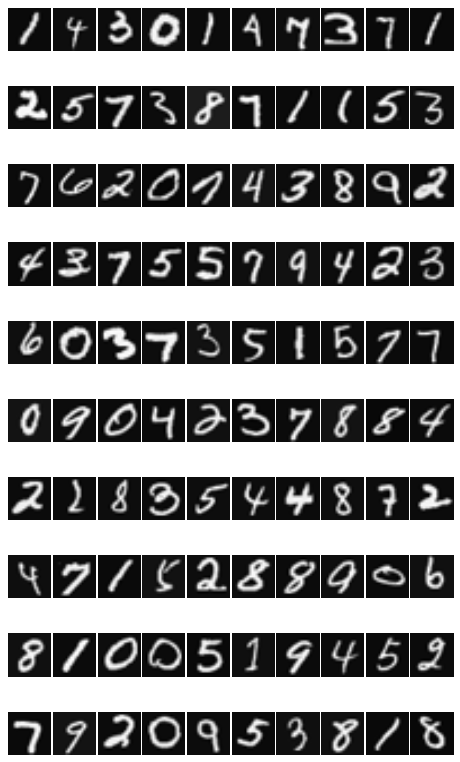

In [62]:
plot_gallery(sel)

## Vectorizing logistic regression

` Since there are 10 classes, you will need to train 10 separate logistic regression classifiers`

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

#### Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)$$

In [63]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

In [64]:
def cost_function(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    J = -1*(np.log(h).T.dot(y)+ np.log(1-h).T.dot(1-y))/m
    return J[0]

In [65]:
def gradientLog(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta_in.reshape(-1,1)))
    grad =1/(m)*X.T.dot(h-y)
    return(grad.flatten())

In [66]:
def optimizeTheta(theta_in,X,y):
    result = sp.optimize.minimize(cost_function, theta_in, args= (X,y),jac=gradientLog)
    return result

## Regualarized Logistic Regression

#### Cost function

$$ 
\begin{align*}
J(\theta) = - \frac{1}{m} \sum_{i=1}^m \large[ y^{(i)}\ \log (h_\theta (x^{(i)})) + (1 - y^{(i)})\ \log (1 - h_\theta(x^{(i)}))\large] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2
\end{align*}
$$


$$ 
\begin{align*}
& \text{Repeat}\ \lbrace \newline
& \ \ \ \ \theta_0 := \theta_0 - \alpha\ \frac{1}{m}\ \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_0^{(i)} \newline
& \ \ \ \ \theta_j := \theta_j - \alpha\ \left[ \left( \frac{1}{m}\ \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \right] &\ \ \ \ \ \ \ \ \ \ j \in \lbrace 1,2...n\rbrace\newline
& \rbrace
\end{align*}
$$

#### Gradient

A small modification leads to..
$$
\theta_j := \theta_j(1 - \alpha\frac{\lambda}{m}) - \alpha\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}
$$

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$

In [75]:
reg = 1

In [76]:
def cost_function_reg(theta, X, y, reg = reg):
    m = y.size
    h = sigmoid(X.dot(theta))
    J = (-1*(np.log(h).T.dot(y)+ np.log(1-h).T.dot(1-y))/m) + ((reg * np.sum(np.square(theta[1:])))/(2*m))
    return J[0]

In [77]:
def gradientLogReg(theta,X,y,reg):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    # don't reg intercept, how do i vectorize this?
    grad = (X.T.dot(h-y))/m + (reg) * (np.r_[[[0]],theta[1:].reshape(-1,1)])/m
    return grad.flatten()

In [78]:
def optimizeThetaReg(theta_in,X,y):
    result = sp.optimize.minimize(cost_function_reg, theta_in, args=(X, y, reg), 
                  method= None, jac=gradientLogReg, options={'maxiter':10000})
    return result.x

### One-vs-all classification

In [121]:
def oneVsAll(X,y,num_labels,reg):
    m,n = X.shape
    all_theta = np.zeros((num_labels,n+1))
    X = np.c_[np.ones((m,1)),X]
    for c in np.arange(1,num_labels+1):
        # only place where indexing from 1 really makes sense!
        initial_theta = np.zeros((n+1,1))
        reg = reg
        result = sp.optimize.minimize(cost_function_reg, initial_theta, args = (X,(y==c)*1,reg), method = None,
                                     jac=gradientLogReg,options={'maxiter':100})
        all_theta[c-1,:] = result.x
    return all_theta

In [136]:
%timeit theta_predictions = oneVsAll(X,y,10,0.1)

1 loops, best of 3: 19.3 s per loop


## One-vs-all prediction

In [143]:
def predictOneVsAll(theta_pred,X):
    X = np.c_[np.ones((m,1)),X]
    probs = sigmoid(X.dot(theta_pred.T))
    # have to return the index of max
    # add one because of python's zero indexing
    return(np.argmax(probs,axis=1)+ 1)

In [144]:
pred = predictOneVsAll(theta_predictions,X)

In [161]:
print 'The accuracy is %f' %np.mean(pred == y.flatten())

The accuracy is 0.949600


Not too bad for a linear model!